## Step 1: Reading the data

The data for this project comes from the "Physionet" database collected by the Children's Hospital of Boston. The data consits of EEG recordings gathered from 10 children and young adults with medically resistant epilepsy. Each test subject has around 50 hours of recordings so there's a lot of data! A neurologist then went through all the data by hand and identified all the seizures. So each sample gets a value of `1` if it corresponds to a seizure and a `0` if not. The data was collected in a hospital setting and more subjects have data from at least 20 different electrodes. However, to be closer to the environment faced by developers of embedded systems we'll only look at two channels that are located near the temples. You can see some more detailed information about the data [here](https://physionet.org/content/chbmit/1.0.0/).

In the `../input/` folder you'll find a file `eeg_data_temples2.h5` which contains all the EEG recordings for the two channels we're interested in. Our first step will be to read this data into Python and convert it into a format our algorithm can work with. To do so, we'll use the `tables` library for Python which can read the `HDF5` file format which is used to store the EEG data.

## Side Note: Model Estimation and Feature Extraction

For this task we want to classify a short segment (commonly called a "window") of an EEG recording (4 seconds to be exact) as either being a during a seizure or not. To do so, we will use a logistic regression model. Very succinctly, a lostic regression is a statistical model which can be used predicts the value of a binary random variable (i.e. a random variable which takes on exactly two discrete values) known as the "outcome" or "dependent variable," given a set of observations of one or more "input" or "independent" variables. Very succinctly, suppose we have two input variables $x_1 \in \mathbb{R}$ and $x_2 \in \mathbb{R}$ (where $\mathbb{R}$ denotes the real numbers) and a discrete outcome $y \in \{0,1\}$. Then logistic regression first computes a linear function of those variables:

$$ z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $$

and then "squashes" $z$ through a function (called the logistic-sigmoid) which converts $z$ into a probability. Putting both steps together we have:

$$ Pr(y = 1 | x_1, x_2) = \sigma(\beta_0 + \beta_1 x_1 + \beta_2 x_2) $$

where $\sigma(x) = \frac{1}{1+e^{-x}}$ is the logistic sigmoid. In general, we don't know $\beta_0, \beta_1, \beta_2$ and need to *estimate* them from some data. The $\beta$ are known as the model "parameters" and the process of estimating them is called "parameter estimation" (there's an entire ECE course that is just about parameter estimation). The algorithm to do this is somewhat complicated, but fortunately some other people have already implemented it for us. We just need to give their implementation a bunch of data corresponding to several observed values of $x_1$ and $x_2$ along with the correct value of $y$ for those data points. Their algorithm will give us back the "best" values of $\beta$. Then, if we observe values for $x_1$ and $x_2$ for which we *do not* know the correct value of $y$, we can plug those into the equation above along with the estimated values for the $\beta$ and compute the probabilty that these $x$ correspond to $y=1$. 

This is a very over-simplified description of logistic regression which has a number of interesting interpretations both statistically and geometrically which you're encouraged to read more about [here](https://en.wikipedia.org/wiki/Logistic_regression). In particular, I recommend reading the first two "examples" to get a bit more technical understanding of how the model works and how we define the "best" value of the $\beta$.

In our case the outcome variable will be "given the last four seconds of EEG data, is the person having a seizure?" So in this case our $x$ variables will be some variables which summarize the last four seconds of observed EEG data and our $y$ variable will be a $1$ if the person was having a seizure at any point in the last four seconds. The question of how to best summarize the signal so that a logistic regression gives good results has been the subject of considerable research and people have proposed a bunch of different values to extract from the seizure which may be useful. In this case we'll use a very simple model that uses the mean and variance of the signal in each window along with some features of the "frequency domain" which are well known to be useful by medical researchers. The term "frequency domain" refers to the representation of the signal obtained by computing its Fourier Transform. Recall that the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) takes a signal which is measured as a function of time and decomposes it into a superposition of primitive waves oscilating at different frequencies. In many cases (including this one), the relative importance of these waves tells us useful things about the signal so it's very common to analyze signals in the frequency domain. If you don't know about Fourier Transforms, that's fine, but I recommend reading about them (or look up the 3Blue1Brown video about them) because they are very interesting.

So our first task will be to read the raw data collected on EEG and extract the various "features" from the raw signal.

In [3]:
import tables
import logging # for debug logging
from tqdm import tqdm # to display a loading bar for iterables

import numpy as np
import pandas as pd

from scipy import signal
from multiprocessing import Pool
from functools import partial

import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import pairwise_kernels
import os.path # to find and create directories

import matplotlib.pyplot as plt

#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def kernel(X):
    N = len(X)
    K = np.ones((N,N))
    for ixi in tqdm.tqdm(range(N)):
        P = X[ixi]
        for ixj in range(ixi+1,N):
            Q = X[ixj]
            v = min(P.shape[1], Q.shape[1])
            K[ixi,ixj] = (1/float(v))*np.square(np.linalg.norm(P.T.dot(Q)))

    ixs = np.tril_indices(N)
    K[ixs] = K.T[ixs]
    return K

# downsample training data to balance number of non-seizure and seizure data points (50/50 in this case)
def downSample(data_train, label_train):

    # since labels are bools, number of Trues is the number of seizures
    numSeizures = np.sum(label_train)
    
    # mask to select all non-seizure data for subject
    isFalse = (label_train == False)
    
    # select all non-seizure data for subject
    data_train_false = data_train[isFalse, :]

    # randomly sample numSeizures rows from non-seizure data
    sample = np.random.randint(np.size(data_train_false, 0), size = numSeizures)
    data_train_false = data_train[sample, :]
    
    if debug:
        print('Number of seizures {}'.format(numSeizures))
        print('Shape of false data after sample {}'.format(data_train_false.shape))
    
    # create same amount of zeroes (False) as number of seizures
    label_false = np.zeros(numSeizures, dtype='bool')

    if debug:
        print(label_false)
    
    # capture all data marked as seizure
    data_train_true = data_train[np.logical_not(isFalse), :]
    label_true = np.ones(numSeizures, dtype='bool')
                                  
    if debug:
        print(label_true)
    
    data_train_down = np.concatenate((data_train_false, data_train_true))
    label_train_down = np.concatenate((label_false, label_true))

    if debug:
        print('Shape of false data labels after sample {}'.format(label_train_down.shape))
        print(label_train_down)
    
    return data_train_down, label_train_down

In [3]:
# Let's examine the file. It contains several "nodes" each of which corresponds to one test subject
# Each node has several children which each correspond to (roughly) one hour of data.

# h5_file = tables.open_file("../input/eeg_data_temples2.h5")
# print(h5_file)

In [4]:
# This function computes the relative power in several frequency bands which
# are generally known to be medically relevant

def compute_band_relpower(X):
    band_relpower = []
    bands = [(0.5,4), (4,8), (8,13), (13,32), (32,60)]

    freqs, psd = signal.welch(X, fs=256.0, axis=0)
    fr_res = freqs[1] - freqs[0]

    where = lambda lb, ub: np.logical_and(freqs >= lb, freqs < ub)
    abs_power = np.concatenate(
            [integrate.simps(psd[where(lb, ub),:], dx=fr_res, axis=0
                ).reshape(1,-1) for lb, ub in bands]
        )
    total_power = integrate.simps(psd, dx=fr_res, axis=0).astype(np.float64)
    abs_power[:,total_power == 0] = 0
    total_power[total_power == 0] = -1
    band_relpower = (abs_power / total_power).ravel()    

    return band_relpower

In [5]:
# Now we'll read the data into a Python data structure and 
# extract features of the signal to be used in a statistical 
# algorithm for prediction
def readData():
    
    # try to load data from files
    try:
        print('Loading features.npy...')
        features = np.load('data/features.npy')

        print('Loading labels.npy...')
        labels = np.load('data/labels.npy')

        print('Loading subjects.npy...')
        subjects = np.load('data/subjects.npy')

        print('All data was succesfully loaded!\n')
        return features, labels, subjects

    # rebuild data if a file is missing
    except IOError:
        print('File was not found. Rebuilding data...')

    # open file
    h5_file = tables.open_file("../input/eeg_data_temples2.h5")

    directory = './data/'
    
    sampling_rate = 256     # how many observations (samples) are gathered every? second
    window_size_seconds = 4 # how many seconds of data do we want in a window?
    stride_seconds = 2      # how far should we advance the window at each step?

    window_size = window_size_seconds*sampling_rate
    stride = stride_seconds*sampling_rate

    features = []
    labels   = []
    subjects = []
    for node in h5_file.walk_nodes("/", "CArray"):
        node_data = node.read()
        subject_id = node._v_name.split("/")[0].split("_")[0]

        # The data for each node is an N x 3 numpy array (a matrix)
        # The first two columns are the EEG data and the third is an
        # indicator variable which is equal to 1 if the observation 
        # corresponds to a seizure

        X, y = node_data[:,:-1], node_data[:,-1]
        num_obs, num_channels = X.shape

        # Now we want to convert our data matrix (X) into a sequence
        # of overlapping windows

        for ix in range(window_size, num_obs, stride):
            X_w = X[ix-window_size:ix,:]

            # now let's extract the "features" mentioned above
            # TODO: compute the mean and variance of both channels of data
            # hint: use np.mean and np.var and look up the "axis" argument
            band_relpower = compute_band_relpower(X_w)
            means = np.mean(X_w, axis = 0)    # compute mean for each col
            variances = np.var(X_w, axis = 0) # compute var for each col
            feature_vector = np.concatenate((band_relpower, means, variances))
            features.append(feature_vector)

            labels.append(np.any(y[ix-window_size:ix]))
            subjects.append(subject_id)
        
    features = np.vstack(features) # stack each tuple in list on top of each other
    labels = np.array(labels)      # converting these lists to numpy arrays
    subjects = np.array(subjects)
    
    # make directory if it dosent exist
    if not os.path.isdir(directory):
        os.mkdir(directory)

    # save arrays to respective files so we don't need to do this again
    np.save('data/features', features)
    np.save('data/labels', labels)
    np.save('data/subjects', subjects)
    
    # close file
    h5_file.close()

    return features, labels, subjects

In [6]:
def getTrainAndTest(subID, data, label, subjects):

    is_test_set = (subjects != subID) # mask to select data for everyone, but subID

    data_train = data[is_test_set, :] # get entire row of subject in data
    label_train = label[is_test_set] # get label of row
    data_train, label_train = downSample(data_train, label_train)

    if debug:
        print('getTrainAndTest - data {}, label {}'.format(data_train.shape, label_train.shape))

    # TODO: use the "is_test_set" variable to extract the rows of `X`
    # corresponding to the test subject.
    data_test = data[np.invert(is_test_set), :]
    label_test = label[np.invert(is_test_set)]
    
    # As a final step, we'll resacle each of our features so that they
    # have a mean of zero and a standard deviation of one. Again, the 
    # reason why we do this is a bit technical, but in general ML models
    # don't like it when the features are on different scales.

    S = StandardScaler()
    data_train = S.fit_transform(data_train)
    data_test = S.transform(data_test)

    if debug:
        print('getTrainAndTest 2- data {}, label {}'.format(data_train.shape, label_train.shape))
    
    return data_train, label_train, data_test, label_test

In [7]:
# TODO: construct a logistic regression object and call it's .fit()
# method with the training data
def trainModel(data_train, label_train, data_test, label_test, subID):

    directory = 'probs/'
    filename = '{}model'.format(subID)
    file_path = directory + filename

    if debug:
        print(label_train[0])
        print(label_train[-1])
        
    clf = LogisticRegression(random_state=0)
    clf.fit(data_train, label_train)

    # Now let's evaluate the performance of our model on the train and
    # test set. We can use the "predict" method of the model to obtain
    # predictions and compare these against the correct values
    # TODO: compute the accuracy of the model on the training and testing
    # datasets

    label_pred_train = clf.predict(data_train)
    train_accuracy = np.mean(np.equal(label_pred_train, label_train))

    label_pred_test = clf.predict(data_test)
    test_accuracy = np.mean(np.equal(label_pred_test, label_test))

    if not os.path.isdir(directory):
        os.mkdir(directory)

    # save best model so we can analyze probabilities of best fit model later
    probs = clf.predict_proba(data_test)
    np.save(file_path, probs)

    return label_pred_train, label_pred_test
    #print("Training accuracy was: {}".format(train_accuracy))
    #print("Test accuracy was: {}".format(test_accuracy))

In [8]:
# TODO: compute the "confusion matrix" for the model
# (hint: use the "confusion_matrix" function) and then use this
# to compute the true negative rate and true positive rate
def computeTrueNegAndPos(label_pred_test, label_test):
    
    cfn = confusion_matrix(label_pred_test, label_test)
    
    # number of correctly classified 0's divided by number of 0's in test
    true_negatives = cfn[0][0] / (len(label_test) - sum(label_test)) 
    
    # number of correctly classified 1's divided by number of 1's in test
    true_positives = cfn[1][1] / sum(label_test)
    
    return true_negatives, true_positives
    #print("True negative rate: {}".format(true_negatives))
    #print("True positive rate: {}".format(true_positives))

In [9]:
#print(np.mean(y_train))

In [10]:
# TODO: draw a random sample of the negative (0) training examples
# to ensure there are an equal number of 0's and 1's in the training
# data and estimate the model again.

# print("Training accuracy was: {}".format(train_accuracy))
# print("Test accuracy was: {}".format(test_accuracy))

# print("True negative rate: {}".format(true_negatives))
# print("True positive rate: {}".format(true_positives))

In [11]:
def testModelOnSubject(subID, features, labels, subjects):
    
    """
    Description:
        Train model on data, excluding subID. Then, test the model using subID as
        the validation set.
    
    Input:
        String subID - ID of the subject we exclude from training and use for validation.
        
    """
    
    data_train, label_train, data_test, label_test = getTrainAndTest(subID, features, labels, subjects)
    label_pred_train, label_pred_test = trainModel(data_train, label_train, data_test, label_test, subID)
    
    # only computing for test set
    true_negatives, true_positives = computeTrueNegAndPos(label_pred_test, label_test)
    
    return true_negatives, true_positives

MMD

\begin{equation}
    ||X - Q_W||_{2}^{2} = \frac{1}{M^2}\sum_{i,j = 1}^{M}k(x_i, x_j)-\frac{2}{MW}\sum_{i=1}^{M}\sum_{j=1}^{W}k(x_i,q_j)+\frac{1}{W^2}\sum_{i,j=1}^{W}k(q_i, q_j)
\end{equation}

In [3]:
def rbf_kernel(Y,X):
    result = sklearn.metrics.pairwise.rbf_kernel(X, Y)
    return result

def mmd(subID, data, labels, subjects, kernel='gaussian'):
    
    
    
    """
    Parameters:
        subID - ID of subject used in validation
        features - n x m training data (n training points, m features)
        labels - n corresponding labels for each training point
        subjects - corresponding subject ID's for each training point
        kernel - name of the kernel function used in MMD. By default, uses gaussin
        
        (1044454, 14)
        (1044454,)
        (1044454,)
        
    Returns:
        true_negative - true negative value
        true_positive - true positive value
    """
    
    SEIZURE = 1
    WIN_SIZE = 100
    BATCH_SIZE = 100
    
    preds = []
    truth = []
    
    seiz_score  = 0
    nseiz_score = 0
    
    # mask for training data
    is_test_set  = (subjects != subID)
    
    train_data   = data[is_test_set, :]
    train_labels = labels[is_test_set]
    
    sub_data     = data[np.invert(is_test_set), :]
    sub_labels   = labels[np.invert(is_test_set)]
    
    is_seizure   = (train_labels == SEIZURE)
    
    seizures = train_data[is_seizure, :]
    non_seizures = train_data[np.invert(is_seizure), :]    
    
    assert(len(train_data) + len(sub_data) == len(data))
    assert(len(seizures) + len(non_seizures) == len(train_data))
  

    K = kernel(Z)
    mmd = []
    for N in range(1,Z.shape[0]):
        M = Z.shape[0] - N
        Kxx = K[:N,:N].sum()
        Kxy = K[:N,N:].sum()
        Kyy = K[N:,N:].sum()
        mmd.append(np.sqrt(
            ((1/float(N*N))*Kxx) + 
            ((1/float(M*M))*Kyy) -
            ((2/float(N*M))*Kxy)
        ))




#     tqdm.write('Seizure kernel')
    
# #     seiz_Kxx = sklearn.metrics.pairwise.rbf_kernel(seizures, seizures)
# #     seiz_Kxx = pairwise_kernels(seizures, seizures, metric='rbf')
    
# #     seiz_sum1 = np.sum(seiz_Kxx)/(len(seizures)*len(seizures))
# #     seiz_sum2 = 0

#     tqdm.write('Non-seizure kernel')
#     nseiz_Kxx = 0
    
#     batches = np.array_split(non_seizures, BATCH_SIZE)
#     print(len(batches))
#     result = 0
    
# #     for batch in tqdm(batches):
# #         rbf_kernel(non_seizures, batch)
    
#     with Pool(4) as p:
#         result = list(tqdm(p.imap_unordered(partial(rbf_kernel, X=non_seizures), batches), total=len(batches)))
#         p.close()
#         p.join()
        
#     print(len(result))
#     return None
    
# #     for data in tqdm(non_seizures):
# #         dot_prods = sklearn.metrics.pairwise.rbf_kernel(data.reshape(1, -1), non_seizures)
# #         nseiz_Kxx += np.sum(dot_prods)
    
#     nseiz_sum1 = np.sum(nseiz_Kxx)/(len(non_seizures)*len(non_seizures))
#     nseiz_sum2 = 0
    
#     # slide a window over subject data
#     for idx in tqdm(range(len(sub_data) - WIN_SIZE + 1), desc='Window loop'):

#         window_data  = sub_data[idx:idx+WIN_SIZE-1, :]
#         window_label = any(sub_labels[idx:idx+WIN_SIZE-1])
#         truth.append(window_label)
#         Kyy = pairwise_kernels(window_data, window_data, metric='rbf')
#         seiz_Kxy  = pairwise_kernels(seizures, window_data, metric='rbf')
#         nseiz_Kxy = pairwise_kernels(non_seizures, window_data, metric='rbf')
        
#         seiz_sum2  = np.sum(seiz_Kxy)*2/(len(seizures)*len(window_data))
#         sseiz_sum2 = np.sum(nseiz_Kxy)*2/(len(non_seizures)*len(window_data))
        
#         sum3 = np.sum(Kyy)/(len(window_data)*len(window_data))
        
#         seiz_score  = seiz_sum1  - seiz_sum2  + sum3
#         nseiz_score = nseiz_sum1 - nseiz_sum2 + sum3

#         preds.append(seiz_score > nseiz_score)
     
    true_negative, true_positives = computeTrueNegAndPos(preds, truth)
    
    return true_negative, true_positives

In [13]:
def gaussianKernel(x, y):
    """
    Note: Also known as a radial basis function.
          Kernel 3 from kernel functions link below.
    
    Parameters:
        x - 1D vector of length N
        y - 1D vector of length N
    
    Returns:
        The value of the kernel function, i.e. a scalar
    """
    sql2norm = np.sum(np.square(x - y))
    sigma = 2
    coeff = -1/2*(sigma*sigma)
    
    return np.exp(sql2norm * coeff)

In [14]:
def plotData():
    
    """
    Plot probability of seizure (and with non-seizure later) over time using
    the best model found during training.
    """
    
    directory = './probs/'
    filename = '{}model.npy'.format(best[0])
    file_path = directory + filename

    probs = np.load(file_path)

    print('Building plot of best model...')

    time = np.arange(1, len(probs) + 1)
    #val_neg = probs[ : , 0]
    val_pos = probs[ : , 1]

    # building plot
    plt.figure(figsize=(30, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot(time, val_pos, "s-")
    ax1.set_ylabel("Probability of Seizure")
    ax1.set_xlabel("Current 4-second Time Interval")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Probability of Seizure Over Time')
    
    print('Showing results for the best model:', best[0], '(leaving out non-seizures for now)')
    
    plt.tight_layout()
    plt.show()

In [15]:
def printTable(tableData):
    print('| Subject ID | True Negative Rate | True Positive Rate |')
    print('--------------------------------------------------------')
    
    for data in tableData:
        print('|', data[0], " " * (9 - len(data[0])), 
              '|', '{:.5f}'.format(data[1]), " " * (10), 
              '|', '{:.5f}'.format(data[2]), " " * (10), '|')
    print('--------------------------------------------------------\n')

### Things to Know

1) Data to train model is saved in the "src/data/" folder.

2) Probabilities for each subject is saved in the "src/probs/" folder.

3) I have not plotted seizure and non-seizure data against each other due to noise. This will get done once I confirm the correctness of the plot.

### TODO

1) Finish plot

### Kernels

List of kernels for MMD: http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/

In [16]:
debug = False

In [17]:
def bar(y,x):
    t = x @ y.T
    print('done')
    return t

def foo():
    mat1 = np.ones((1000000, 14))
    test = (np.ones((1,14)), np.ones((1,14)))

    with Pool(8) as p:
    # this will not finish
        result = p.map(partial(bar, x=mat1), test)
        p.close()
        p.join()

In [18]:
if __name__ == "__main__":

    subjectID = 'chb01'
    features, labels, subjects = readData()
    #uniqueSubs = ['chb01', 'chb02']
    uniqueSubs = set(subjects)
    tableData = []
    best = None
    foo()
    
    #print(features.shape)

    #print('Running model...')
    for sub in uniqueSubs:
        #true_neg, true_pos = testModelOnSubject(sub, features, labels, subjects)
        true_neg, true_pos = mmd(sub, features, labels, subjects)

        if debug:
            print('main - sub {}, true_neg {}, true_pos {}'.format(sub, true_neg, true_pos))
            print([sub, true_neg, true_pos])

        currSubResults = [sub, true_neg, true_pos]

        if best == None or true_pos > best[2]:
            best = currSubResults

        tableData.append(currSubResults)
    
    print('Done! Results are shown below.\n')  
    printTable(tableData)
    

    plotData()

Loading features.npy...
File was not found. Rebuilding data...


NameError: name 'integrate' is not defined

In [28]:
import sys
import math
from sklearn.metrics.pairwise import rbf_kernel
import logging
import os
from scipy import integrate
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis

LOG = logging.getLogger(os.path.basename(''))

SF = 256
SEG_LENGTH = 512
BANDS = [(1,4), (4,8), (8,12), (12,30)]
EMBDEM = 7
DELAY  = 1

def main():
    kernel_name = "rbf"
#     if len(sys.argv) > 1:
#         kernel_name = sys.argv[1]

    if kernel_name == "rbf":
        kernel = rbf_kernel
    elif kernel_name == "laplacian":
        kernel = laplacian_kernel
    elif kernel_name == "linear":
        kernel = linear_kernel
    elif kernel_name == "polynomial":
        kernel = polynomial_kernel
    else:
        raise NotImplementedError("Kernel: {} is invalid".format(kernel_name))
    
    LOG.info("Using kernel: {}".format(kernel_name))
    
    dirname = "../temp/psd/{}".format(kernel_name)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with tables.open_file("../input/eeg_data_temples2.h5") as h5_file:
        for node in h5_file.walk_nodes("/", "CArray"):
            LOG.info("Processing: {}".format(node._v_name))
            if len(node.attrs.seizures) != 1:
                continue
            
            data = node.read()
            seizures = node.attrs.seizures
            X, y = data[:,:-1], data[:,-1]
            start = np.min(np.where(y > 0)[0])
            stop = np.max(np.where(y > 0)[0])

            buff_mins = 20
            minv = max(0, start-(buff_mins*60*SF))
            maxv = min(X.shape[0], stop+(buff_mins*60*SF))
            data = data[minv:maxv,:]
            X = X[minv:maxv,:]
            y = y[minv:maxv]
            
            sos = signal.butter(3, 50, fs=SF, btype="lowpass", output="sos")
            X = signal.sosfilt(sos, X, axis=1)
            Z = []
            q = []
            moments   = []
            
            for ix in range(SEG_LENGTH, X.shape[0], SEG_LENGTH):
                
                segment   = X[ix-SEG_LENGTH:ix,:]
                ord_freqs = ordinal_patterns(segment, EMBDEM, DELAY)
                
                means         = np.mean(segment, axis=0) # append mean
                variances     = np.var(segment, axis=0)  # append variance 
                skew_         = skew(segment, axis=0)
                kurtosis_     = kurtosis(segment, axis=0)
                perm_entro    = s_entropy(ord_freqs, EMBDEM)/np.log(math.factorial(EMBDEM))
                band_relpower = compute_band_relpower(segment)
                other_feats   = np.append(band_relpower, perm_entro)

                moments.append(np.concatenate((means, variances, skew_, kurtosis_)))
                Z.append(other_feats)
                q.append(np.any(y[ix-SEG_LENGTH:ix]))
            
            moments = np.vstack(moments)
            scaler = MinMaxScaler()
            moments = scaler.fit_transform(moments)
            
            Z = np.vstack(Z)
            Z = np.hstack((Z, moments))
            y = np.array(q)
            
            #ignore below
            
#             band_names = ["{}-{}".format(x,y) for x,y in BANDS]
#             colnames = [(x + "_1", x + "_2") for x in band_names]
        
#             bands = pd.DataFrame(Z, columns=[n for x in colnames for n in x])
#             plt.close()
#             bands.plot()
#             plt.axvline(x=np.min(np.where(y > 0)[0]), linewidth=2, color="red")
#             plt.axvline(x=np.max(np.where(y > 0)[0]), linewidth=2, color="red")            
#             plt.legend()
#             plt.savefig("{}/{}_signal_relpower.png".format(dirname, node._v_name))

            K = kernel(Z)
            mmd = []
            for N in tqdm(range(1,Z.shape[0])):
                M = Z.shape[0] - N
                Kxx = K[:N,:N].sum()
                Kxy = K[:N,N:].sum()
                Kyy = K[N:,N:].sum()
                mmd.append(np.sqrt(
                    ((1/float(N*N))*Kxx) + 
                    ((1/float(M*M))*Kyy) -
                    ((2/float(N*M))*Kxy)
                ))
            
            ws = []
            mmd = np.array(mmd)
            mmd_corr = np.zeros(mmd.size)
            for ix in range(1,mmd_corr.size):
                w = ((Z.shape[0]-1) / float(ix*(N-ix)))
                ws.append(w)
                mmd_corr[ix] = mmd[ix] - w*mmd.max()

            # mmd = mmd[200:-200]
            # mmd_corr = mmd_corr[200:-200]
            plt.close()
            plt.plot(mmd, label="MMD")
            plt.plot(mmd_corr, label="MMD (Corrected)")
            plt.axvline(x=np.min(np.where(y > 0)[0]), linewidth=2, color="red")
            plt.axvline(x=np.max(np.where(y > 0)[0]), linewidth=2, color="red")
            plt.savefig("{}/{}_mmd.png".format(dirname, node._v_name))


def ordinal_patterns(ts, embdim, embdelay):

    time_series = ts
    possible_permutations = math.factorial(embdim)
    lst = list()
    
    # Number of vectors is T - t(D - 1)
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series[i:(embdim+i)]))
        lst.append(sorted_index_array)
        
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    
    # Fix missing entries
    if len(freq) != possible_permutations:
        for i in range(possible_permutations-len(freq)):
            freq.append(0)
    freq = [x/possible_permutations for x in freq]
    return(freq)
    
def s_entropy(freq_list, d):

    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
        
    sh_entropy = -sh_entropy
    
    return(sh_entropy)
            
def compute_band_relpower(X):
    freqs, psd = signal.welch(X, SF, axis=0)
    freq_res = freqs[1] - freqs[0]
    total_power = integrate.simps(psd, dx=freq_res, axis=0)

    where = total_power <= 1e-5
    total_power[where] = -1

    band_relpower = []
    for lb, ub in BANDS:
        idx = np.logical_and(freqs >= lb, freqs < ub)
        band_power = integrate.simps(psd[idx,:], dx=freq_res, axis=0)
        relpow = band_power / total_power
        relpow[where] = 0
        band_relpower.append(relpow)
    
    return np.concatenate(band_relpower)

100%|██████████| 1225/1225 [00:01<00:00, 1146.74it/s]


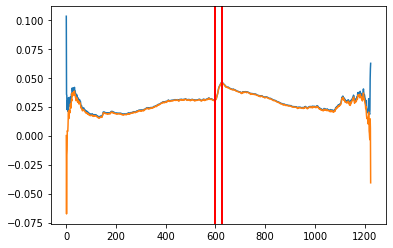

In [29]:
main()